# Importing relevant libraries and defining constants

In [353]:
from math import *
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from scipy.optimize import minimize
import matplotlib.pyplot as plt



taper = 0.45
rho = 2710 #kg/m^3 for Aluminium
W_eng = 41.8 #kg
E = 70e9 #MPa
poisson = 0.3
pb=2.5 #post-buckling ratio
beta=1.42
g=5
sigma_yield = 430e6 #MPa
m_crip = 0.85
sigma_uts = 640e6  #MPa
n_max=2.5

#TEST VALUES
t_spar = 0.003
t_rib = 5e-3
L = 0.875
b_st = 0.15
h_st = 2e-2
t_st = 1e-3
w_st = 2e-2
t = 2e-3

b = 7
c_r = 1.5


First, the chord and the height can be determined as a function of the span-wise location, Equation 1 and Equation 2 being implemented below.

In [354]:
def chord(b, c_r):
    r"""

    Local chord length as a function of span-wise location

    Parameters
    ----------

    b:float
    span

    c_r: float
    root chord

    """
    c = lambda y: c_r - c_r * (1 - taper) * y * 2 / b
    return c

print('Chord at mid half-span:',chord(7,1.5)(7/4),'m')


def height(b, c_r):
    r"""

    Local wing-box height as a function of span-wise location

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord


    """
    c = chord(b, c_r)
    h = lambda Y: 0.17 * c(Y)
    return h

print('Height at mid half-span:',height(7,1.5)(7/4), 'm')

Chord at mid half-span: 1.0875 m
Height at mid half-span: 0.184875 m


# Stiffeners Geometry

The functions related to stringer and spar geometry are defined below. The spar flange could be transformed into a variable as well. However, in order to simplify the problem (as the stringer geometry is completely parameterised) and the variable thickness of the spar as a function of the span-wise location, the spar flange is defined as half of the spar height.

In [355]:

def area_st(h_st,t_st,w_st):
    r"""

    Stringer area

    Parameters
    ----------


    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width


    """
    return t_st * (2 * w_st + h_st)




def I_st(h_st,t_st,w_st):
    r"""

    Stringer moment of inertia

    Parameters
    ----------


    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width


    """
    Ast=area_st(h_st,t_st,w_st)
    i = t_st * h_st ** 3 / 12 + w_st  * t_st ** 3 / 12 + 2 * Ast * (0.5 * h_st) ** 2
    return i




def w_sp(b, c_r):
    r"""
    Spar web length

    Parameters
    ----------


    b: float
    span

    c_r: float
    root chord

    """
    h = height(b, c_r)
    i = lambda z: 0.5 * h(z)
    return i




def I_sp(b, c_r,t_sp):
    r"""

    Spar moment of inertia

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness


    """
    h = height(b, c_r)
    wsp = w_sp(b, c_r)
    i = lambda z: t_sp * (h(z) - 2 * t_sp) ** 3 / 12 + 2 * wsp(z) * t_sp ** 3 / 12 + 2 * t_sp * wsp(z) * ( 0.5 * h(z)) ** 2
    return i


def I_xx(b,c_r,t_sp,b_st, h_st,t_st,w_st,t_sk):
    r"""

    Total momnet of inertia as a function of the span-wise location

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness



    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    h = height(b, c_r)
    nst = n_st(c_r, b_st)
    Ist = I_st(h_st,t_st,w_st)
    Isp = I_sp(b, c_r,t_sp)
    A = area_st(h_st,t_st,w_st)
    i = lambda z: 2 * (Ist + A * (0.5 * h(z)) ** 2) * nst + 2 * Isp(z) + 2 * (0.6 * c_r * t_sk ** 3 / 12 + t_sk * 0.6 * c_r * (0.5 * h(z)) ** 2)
    return i

# Tranforming continous varibales in discrete variables

Given the nature of the optimiser, the variables are expressed as continuous values. However, the number of stringers and ribs are integer values and their pitch should be symmetric. Thus, the first two functions compute the number of stringers and ribs as resulted from the values of the continuous variables, and next two functions recalculate the stringer and rib pitch to ensure their symmetric spacing. Lastly, the span-wise location of the ribs is computed in the last function. The rib locations also define the boundaries of the skin panel.

In [356]:
def n_st(c_r, b_st):
    r"""

    Number of stringers

    Parameters
    ----------



    c_r: float
    root chord


    b_st: float
    stringer pitch



    """
    return ceil(0.6 * c_r / b_st) + 1

print('The number of stringers is:',n_st(1.5,0.05))


def n_ribs(b, L):
    r"""

    Number of ribs

    Parameters
    ----------

    b: float
    span


    L: float
    rib pitch


    """
    return ceil(0.5 * b / L) + 1

print('The number of ribs is:',n_ribs(7,0.12))
print('The number of panels is:',n_ribs(7,0.12)-1)


def new_L(b, L):
    r"""

    Ensuring constant rib pitch

    Parameters
    ----------

    b: float
    span


    L: float
    rib pitch


    """
    nr_sect = n_ribs(b, L) - 1
    new_pitch = 0.5 * b / nr_sect
    return new_pitch

print('The symmetric rib pitch is:',new_L(7,0.12))

def new_bst(c_r, b_st):
    r"""

    Ensuring constant stringer pitch

    Parameters
    ----------

    c_r: float
    root chord


    b_st: float
    stringer pitch


    """
    nr_sect = n_st(c_r, b_st) - 1
    new_pitch = 0.6*c_r / nr_sect#TODO CHECK WITH SAULLO, SHOULD BE 0.6*c_r right?
    #new_pitch = *c_r / nr_sect
    return new_pitch

print('The symmetric stringer pitch is:',new_bst(1.5,0.05))


def rib_coordinates(b, L):
    r"""

    Span wise locations of the ribs

    Parameters
    ----------

    b: float
    span


    L: float
    rib pitch


    """
    L_new = new_L(b, L)
    stations = np.arange(0, b / 2 + L_new, L_new)
    return stations

print('The array with span-wise rib location:',rib_coordinates(7,0.12))


The number of stringers is: 19
The number of ribs is: 31
The number of panels is: 30
The symmetric rib pitch is: 0.11666666666666667
The symmetric stringer pitch is: 0.049999999999999996
The array with span-wise rib location: [0.         0.11666667 0.23333333 0.35       0.46666667 0.58333333
 0.7        0.81666667 0.93333333 1.05       1.16666667 1.28333333
 1.4        1.51666667 1.63333333 1.75       1.86666667 1.98333333
 2.1        2.21666667 2.33333333 2.45       2.56666667 2.68333333
 2.8        2.91666667 3.03333333 3.15       3.26666667 3.38333333
 3.5       ]


# Assigning variable thickness 

The user can define in the input how many variable thickness wants to explore, given the number of variables does not exceed the minimum number of panels the optimiser might encounter (defined by the boundaries). Each panel has a constant thickness, and the following function ensures a balanced thickness assignment. The exact transition form a thickness from another would be the result of a FEM analysis.

In [357]:
def t_arr(b, L,t):
    r"""

    Assigning thiknesses to each panel, from thicker to thinner

    Parameters
    ----------

    b: float
    span


    L: float
    rib pitch


    t: np.array
    skin thikness

    """
    b=abs(b)
    L=abs(L)
    nr_ribs = n_ribs(b, L)
    sections = np.zeros(nr_ribs - 1)

    inte = int((len(sections)) // len(t))
    mod = int((len(sections)) % len(t))
    group = int(len(t) - mod)

    arr = np.arange(inte * group, len(sections), inte + 1)

    for i in range(group):
        for j in range(inte):
            sections[inte * i + j] = t[i]
    for i in range(len(arr)):
        cursor = arr[i]
        for j in range(inte + 1):
            sections[cursor + j] = t[group + i]
    return sections

print('Thickness per panel (from root ot tip, in m):',t_arr(7,0.12,[0.0025,0.002,0.0015,0.001]))

Thickness per panel (from root ot tip, in m): [0.0025 0.0025 0.0025 0.0025 0.0025 0.0025 0.0025 0.002  0.002  0.002
 0.002  0.002  0.002  0.002  0.0015 0.0015 0.0015 0.0015 0.0015 0.0015
 0.0015 0.0015 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001 ]


# Weight computations

The following functions express the weight per component first, leading to the total weight of the wing, which represents the optimisation objective function. Equation 8 to Equation 10 are implemented below.

In [358]:
def rib_weight(b, c_r, t_rib):
    r"""

    Rib weight as a function of the span-wise location

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord


    t_rib: float
    rib thickness

    """
    c = chord(b, c_r)
    h = height(b, c_r)
    w_rib = lambda z: 0.6 * c(z) * h(z) * t_rib * rho
    return w_rib
print('The mass of the root ribs is:',rib_weight(7, 1.5, 0.003)(0), 'kg')

def panel_weight(b, c_r,t_sp, L, b_st, h_st,t_st,w_st,t):
    r"""

    Weight of one panel

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness


    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    t_sk = t_arr(b, L,t)
    c = chord(b, c_r)
    h = height(b, c_r)
    nst = n_st(c_r, b_st)
    stations = rib_coordinates(b, L)
    w = np.zeros(len(stations))
    A = area_st(h_st, t_st,w_st)


    for i in range(len(t_sk)):
        vol = lambda z:  rho * (2 * h(z) * t_sp + (pi * (3 * (0.5 * h(z) + 0.15 * c(z)) - sqrt((3 * 0.5 * h(z) + 0.15 * c(z))\
                                                                                               
                        * (0.5 * h(z) + 3 * 0.15 * c(z)))) + 2 * 0.6 * c(z) + sqrt(h(z) ** 2 / 4 + (0.25 * c(z)) ** 2)) *t_sk[i] + A * 2 * nst)
        
        w[i]=trapz([vol(stations[i]),vol(stations[i+1])],[stations[i],stations[i+1]])
    return w
print('The array with panel weights (from root to tip, in kg) is:',panel_weight(7, 1.5,0.003, 0.12, 0.005, 0.005,0.0025,0.004,[0.002]))


def wing_weight(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    Total wing weight

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    b=abs(b)
    c_r=abs(c_r)
    t_sp=abs(t_sp)
    t_rib=abs(t_rib)
    L=abs(L)
    b_st=abs(b_st)
    h_st=abs(h_st)
    t_st=abs(t_st)
    w_st=abs(w_st)
    for i in range(len(t)):
        t[i]=abs(t[i])
    stations = rib_coordinates(b, L)
    skin_weight = panel_weight(b, c_r, t_sp, L, b_st, h_st,t_st,w_st,t)
    cumsum = np.sum(skin_weight)
    rbw = rib_weight(b, c_r, t_rib)

    for i in stations:
        cumsum = cumsum + rbw(i)
    return cumsum

print('The wing weight is:',wing_weight(7, 1.5,0.003,0.003, 0.12, 0.005, 0.005,0.0025,0.004,[0.002]), 'kg')




The mass of the root ribs is: 1.865835 kg
The array with panel weights (from root to tip, in kg) is: [6.28209705 6.23468518 6.1872733  6.13986143 6.09244956 6.04503769
 5.99762581 5.95021394 5.90280207 5.85539019 5.80797832 5.76056645
 5.71315458 5.6657427  5.61833083 5.57091896 5.52350708 5.47609521
 5.42868334 5.38127147 5.33385959 5.28644772 5.23903585 5.19162398
 5.1442121  5.09680023 5.04938836 5.00197648 4.95456461 4.90715274
 0.        ]
The wing weight is: 199.7966391200066 kg


# Shear force diagram

Once the weight distribution within the wing is defined, the shear force distribution span-wise can be determined. The weight of each panel is assigned at the location of the root rib.

In [359]:
def skin_interpolation(b, c_r, t_sp, L, b_st, h_st,t_st,w_st,t):
    r"""

    Shear force due to panel weight only

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness


    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    skin_weight = panel_weight(b, c_r, t_sp, L, b_st, h_st,t_st,w_st,t)
    skin_weight = np.flip(skin_weight)
    skin_weight = np.cumsum(skin_weight)
    skin_weight = np.flip(skin_weight)
    return skin_weight

print('The array with the shear forces due to panel weights at each rib location:',skin_interpolation(7, 1.5,0.003, 0.12, 0.005, 0.005,0.0025,0.004,[0.002]), 'kg')



def rib_interpolation(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    Shear force due to panel and rib weight

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """


    f = skin_interpolation(b, c_r, t_sp, L, b_st, h_st,t_st,w_st,t)
    rbw = rib_weight(b, c_r, t_rib)
    sta = rib_coordinates(b, L)
    f2 = np.repeat(f, 2)
    sta2 = np.repeat(sta, 2)

    rib_w0 = np.zeros(len(sta))
    for i in range(len(rib_w0)):
        rib_w0[i] = rbw(sta[i])
    rib_w = np.flip(rib_w0)
    rib_w = np.cumsum(rib_w)
    rib_w = np.flip(rib_w)

    combined = np.add(f, rib_w)
    combined2 = np.subtract(combined, rib_w0)

    for i in range(len(sta)):
        f2[2 * i] = 9.81 * combined[i]
        f2[2 * i + 1] = 9.81 * combined2[i]
    return sta2, f2




def shear_eng(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    Final weight shear force distribution, including the engines weights

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """


    x = rib_interpolation(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)[0]
    y = rib_interpolation(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)[1]
    f2 = interp1d(x, y)
    x_engine = np.array([0.5 * b / 4, 0.5 * b / 2, 0.5 * 3 * b / 4])
    x_combi = np.concatenate((x, x_engine))
    x_sort = np.sort(x_combi)

    index1 = np.where(x_sort == 0.5 * 3 * b / 4)
    if len(index1[0]) == 1:
        index1 = int(index1[0])
    else:
        index1 = int(index1[0][0])
    y_new1 = f2(x_sort[index1]) + 9.81 * W_eng

    index2 = np.where(x_sort == 0.5 * b / 2)
    if len(index2[0]) == 1:
        index2 = int(index2[0])
    else:
        index2 = int(index2[0][0])
    y_new2 = f2(x_sort[index2]) + 9.81 * W_eng

    index3 = np.where(x_sort == 0.5 * b / 4)
    if len(index3[0]) == 1:
        index3 = int(index3[0])
    else:
        index3 = int(index3[0][0])
    y_new3 = f2(x_sort[index3]) + 9.81 * W_eng

    y_engine = np.ndarray.flatten(np.array([y_new1, y_new2, y_new3]))
    y_combi = np.concatenate((y, y_engine))
    y_sort = np.sort(y_combi)
    y_sort = np.flip(y_sort)

    for i in range(int(index1)):
        y_sort[i] = y_sort[i] + 9.81 * W_eng
    for i in range(int(index2)):
        y_sort[i] = y_sort[i] + 9.81 * W_eng
    for i in range(int(index3)):
        y_sort[i] = y_sort[i] + 9.81 * W_eng
        
        
    plt.plot(x_sort, y_sort)
    plt.xlabel("Span-wise location [m]")
    plt.ylabel("Shear force due to weight [N]")
    plt.grid()
    # plt.show()

    
    return x_sort, y_sort, index1, index2, index3

#print(m_eng(6.99999885e+00, 1.50017237e+00, 3.76696679e-03, 2.15723510e-03, 1.01129988e-02, 9.18472970e-03, 2.43677036e-03, 3.33666862e-03, 3.03720930e-03, [1.54700554e-03, 1.06029439e-03]))


The array with the shear forces due to panel weights at each rib location: [167.83874681 161.55664976 155.32196459 149.13469128 142.99482985
 136.90238029 130.85734261 124.8597168  118.90950286 113.00670079
 107.1513106  101.34333227  95.58276583  89.86961125  84.20386855
  78.58553772  73.01461876  67.49111168  62.01501646  56.58633312
  51.20506166  45.87120206  40.58475434  35.3457185   30.15409452
  25.00988242  19.91308219  14.86369383   9.86171735   4.90715274
   0.        ] kg


# Maximum shear flow

The first function stores the maximum shear force per panel after the superposition between lift and weight. Given the symmetry, the shear flow in one of the halves of the cross-section is requested. The formulas corresponding to Equation 11 to Equation 36 are implemented below. 

The array with maximum shear flow per panel is: [2408.5227399  2301.86830123 2193.38804998 2010.18562153 1898.45438767
 1784.90423788 1669.53680894 1552.35364821 1931.47442102 1811.81186305
 1681.77370692 1552.14300351 1427.7011416  1301.44621848 1173.3789507
 1043.49985731 1419.33358428 1272.60526713 1085.56931167  950.09417566
  812.81771013  673.73905226  532.85694775  390.16970742  763.2056045
  618.20335582  471.40089962  322.79488569  172.3813003    20.15541354] N/m


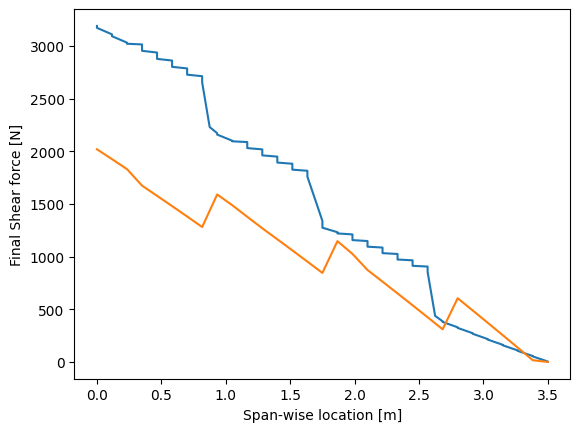

In [360]:


def shear_force(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    Vector conating the maximum shear force per panel

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    shear = shear_eng(b, c_r, t_sp, t_rib, L, b_st, h_st, t_st, w_st,t)[1]
    tarr = t_arr(b, L,t)
    Vz = np.zeros(len(tarr))
    sta = rib_coordinates(b, L)
    aero= lambda y:-151.7143*9.81*y+531*9.81
    for i in range(len(tarr)):
        Vz[i] = aero(sta[i])-shear[2 * i]
    Vz_plot=np.append([Vz],[0])
    plt.plot(sta, Vz_plot)
    plt.xlabel("Span-wise location [m]")
    plt.ylabel("Final Shear force [N]")
    plt.grid()
    #plt.show()
    return Vz

    r"""

    Maximum shear flow [N/m]

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """


def N_xy(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    h1 = height(b, c_r)
    ch = chord(b, c_r)
    tarr = t_arr(b,L,t)
    sta = rib_coordinates(b, L)
    Vz=shear_force(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)
    Nxy = np.zeros(len(tarr))

    for i in range(len(tarr)):
        Ixx1 = I_xx(b,c_r,t_sp,b_st, h_st,t_st,w_st,tarr[i])
        Ixx = Ixx1(sta[i])
        h = h1(sta[i])
        l_sk = sqrt(h ** 2 + (0.25 * c_r) ** 2)
        c = ch(sta[i])

        # Base region 1
        qb1 = lambda z: Vz[i] * tarr[i] * (0.5 * h) ** 2 * (np.cos(z) - 1) / Ixx
        I1 = qb1(pi / 2)

        # Base region 2
        qb2 = lambda z: -Vz[i] * t_sp * z ** 2 / (2 * Ixx)
        I2 = qb2(h)
        s2 = np.arange(0, h+ 0.1, 0.1)

        # Base region 3
        qb3 = lambda z: - Vz[i] * tarr[i] * (0.5 * h) * z / Ixx + I1 + I2
        I3 = qb3(0.6 * c)
        s3 = np.arange(0, 0.6*c+ 0.1, 0.1)

        # Base region 4
        qb4 = lambda z: -Vz[i] * t_sp * z ** 2 / (2 * Ixx)
        I4 = qb4(h)
        s4=np.arange(0, h+ 0.1, 0.1)

        # Base region 5
        qb5 = lambda z: -Vz[i] * tarr[i] / Ixx * (0.5 * h * z - 0.5 * 0.5 * h * z ** 2 / l_sk) + I3 + I4
        I5 = qb5(l_sk)

        # Base region 6
        qb6 = lambda z: Vz[i] * tarr[i] / Ixx * 0.5 * 0.5 * h / l_sk * z ** 2 + I5
        I6 = qb6(l_sk)

        # Base region 7
        qb7 = lambda z: -Vz[i] * t_sp * 0.5 * z ** 2 / Ixx
        I7 = qb7(-h)


        # Base region 8
        qb8 = lambda z: -Vz[i] * 0.5 * h * t_sp * z / Ixx + I6 - I7
        I8 = qb8(0.6 * c)

        # Base region 9
        qb9 = lambda z: -Vz[i] * 0.5 * t_sp * z ** 2 / Ixx
        I9 = qb9(-h)

        # Base region 10
        qb10 = lambda z: -Vz[i] * tarr[i] * (0.5 * h) ** 2 * (np.cos(z) - 1) / Ixx + I8 - I9

        # Redundant shear flow
        A11 = pi * (0.5 * h) / tarr[i] + h / t_sp
        A12 = -h / t_sp
        A21 = - h / t_sp
        A22 = 1.2 * c / tarr[i]
        A23 = -h / t_sp
        A32 = - h / t_sp
        A33 = 2 * l_sk / tarr[i] + h / t_sp



        B1 = 0.5 * h / tarr[i] * trapz([qb1(0),qb1(pi/2)], [0, pi / 2]) + trapz([qb2(0),qb2(0.5*h)], [0, 0.5 * h]) / t_sp - trapz([qb9(-0.5*h),qb9(0)], [-0.5 * h, 0])/ t_sp + trapz([qb10(-pi/2),qb10(0)], [-pi / 2, 0]) * 0.5 * h / tarr[i]
        B2 = trapz([qb2(0),qb2(0.5*h)], [0, 0.5 * h]) / t_sp + trapz([qb3(0),qb3(0.6*c)], [0, 0.6 * c]) / tarr[i] - trapz([qb7(-0.5*h),qb7(0)], [-0.5 * h, 0]) / t_sp + \
             trapz([qb4(0),qb4(0.5*h)], [0, 0.5 * h]) / t_sp + trapz([qb8(0),qb8(0.6*c)], [0, 0.6 * c]) / tarr[i] - trapz([qb9(-0.5*h),qb9(0)], [-0.5 * h, 0]) / t_sp
        B3 = trapz([qb5(0),qb5(l_sk)], [0, l_sk]) / tarr[i] + trapz([qb6(0),qb6(l_sk)], [0, l_sk]) / tarr[i] + trapz([qb4(0),qb4(0.5*h)], [0, 0.5 * h]) / t_sp - \
             trapz([qb9(-0.5*h),qb9(0)], [-0.5 * h, 0]) / t_sp

        A = np.array([[A11, A12, 0], [A21, A22, A23], [0, A32, A33]])
        B = -np.array([[B1], [B2], [B3]])
        X = np.linalg.solve(A, B)

        q01 = float(X[0])
        q02 = float(X[1])
        q03 = float(X[2])

        # Compute final shear flow
        q2 = qb2(s2) - q01 + q02
        q3 = qb3(s3) + q02
        q4 = qb4(s4) + q03 - q02

        max_region2 = max(q2)
        max_region3 = max(q3)
        max_region4 = max(q4)
        determine = max(max_region2, max_region3, max_region4)
        Nxy[i] = determine
    return Nxy

print('The array with maximum shear flow per panel is:',N_xy(7, 1.5,0.003,0.003, 0.12, 0.005, 0.005,0.0025,0.004,[0.002]),'N/m')

# Bending moment diagram

The shear force distribution enables the computation of the bending moment according to Equation 37. 

(array([0.        , 0.11666667, 0.23333333, 0.35      , 0.46666667,
       0.58333333, 0.7       , 0.81666667, 0.875     , 0.93333333,
       1.05      , 1.16666667, 1.28333333, 1.4       , 1.51666667,
       1.63333333, 1.75      , 1.75      , 1.86666667, 1.98333333,
       2.1       , 2.21666667, 2.33333333, 2.45      , 2.56666667,
       2.625     , 2.68333333, 2.8       , 2.91666667, 3.03333333,
       3.15      , 3.26666667, 3.38333333, 3.5       ]), array([5114.79171075, 4955.35813738, 4790.70993999, 4620.68533479,
       4445.59147651, 4265.01201473, 4079.00221721, 3887.53964187,
       3789.73502036, 3714.4575851 , 3559.70278887, 3399.32874166,
       3233.2527093 , 3061.34908325, 2883.80443407, 2700.32299552,
       2510.92386009, 2510.92386009, 2363.41262731, 2209.87450196,
       2050.25622603, 1884.51927957, 1712.59298683, 1534.38791454,
       1349.97004905, 1255.36831933, 1183.08425832, 1033.71345958,
        877.89104395,  715.55437462,  546.65019358,  371.12792246,
    

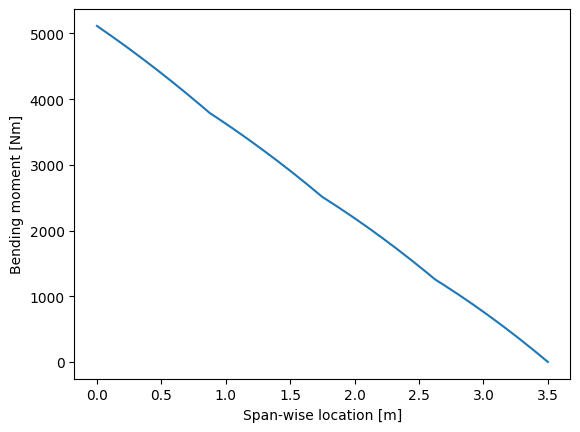

In [361]:

def m(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    Bending moment distribution due to panel and rib weight only

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness
    """

    f = skin_interpolation(b, c_r, t_sp, L, b_st, h_st,t_st,w_st,t)
    sta = rib_coordinates(b, L)
    rbw = rib_weight(b, c_r, t_rib)

    f2 = interp1d(sta, f)

    rib_w = np.zeros(len(sta))
    moment = np.zeros(len(sta))

    for i in range(len(rib_w)):
        rib_w[i] = rbw(sta[i])
    for i in range(1, len(sta)):
        cursor = sta[i] * np.ones(len(sta))
        diff = np.subtract(cursor, sta)
        d = diff > 0
        diff = diff[d]
        rib_w = np.flip(rib_w)
        l = len(diff)
        rib_w = rib_w[0:l]
        produ = np.multiply(rib_w, diff)
        s = np.sum(produ)
        f3=trapz(f2(np.linspace(0,diff[0],10)),np.linspace(0,diff[0],10))
        moment[i] = 9.81 * f3 + 9.81 * s
    moment = np.flip(moment)
    return moment


#print(m(7, 1.5,0.003,0.003, 0.12, 0.005, 0.005,0.0025,0.004,[0.002]))


def m_eng(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    Final bending moment distribution, including the engines

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """


    moment = m(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)
    x = rib_coordinates(b, L)
    f = interp1d(x, moment, kind='quadratic')

    x_engine = np.array([0.5 * b / 4, 0.5 * b / 2, 0.5 * 3 * b / 4])
    x_combi = np.concatenate((x, x_engine))
    x_sort = np.sort(x_combi)

    index1 = np.where(x_sort == 0.5 * 3 * b / 4)
    if len(index1[0]) == 1:
        index1 = int(index1[0])
    else:
        index1 = int(index1[0][0])
    y_new1 = f(x_sort[index1])

    index2 = np.where(x_sort == 0.5 * b / 2)
    if len(index2[0]) == 1:
        index2 = int(index2[0])
    else:
        index2 = int(index2[0][0])
    y_new2 = f(x_sort[index2])

    index3 = np.where(x_sort == 0.5 * b / 4)
    if len(index3[0]) == 1:
        index3 = int(index3[0])
    else:
        index3 = int(index3[0][0])
    y_new3 = f(x_sort[index3])

    y_engine = np.ndarray.flatten(np.array([y_new1, y_new2, y_new3]))
    y_combi = np.concatenate((moment, y_engine))
    y_sort = np.sort(y_combi)
    y_sort = np.flip(y_sort)

    for i in range(int(index1)):
        y_sort[i] = y_sort[i] + 9.81 * W_eng * (0.5 * 3 * b / 4 - x_sort[i])
    for i in range(int(index2)):
        y_sort[i] = y_sort[i] + 9.81 * W_eng * (0.5 * 2 * b / 4 - x_sort[i])
    for i in range(int(index3)):
        y_sort[i] = y_sort[i] + 9.81 * W_eng * (0.5 * b / 4 - x_sort[i])
        
    plt.plot(x_sort, y_sort)
    plt.xlabel("Span-wise location [m]")
    plt.ylabel("Bending moment [Nm]")
    #plt.show()
    return x_sort, y_sort

print(m_eng(7, 1.5,0.003,0.003, 0.12, 0.005, 0.005,0.0025,0.004,[0.002]))


# Distributed compression force

From the bending moment the maximum comprssiove force per panel can be determined as in Equation 39.

In [362]:


def N_x(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    Vector containing the maximum distributed compression load Nx [N/m] per panel

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    sta = rib_coordinates(b, L)
    moment = m_eng(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)[1]
    x_sort = m_eng(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)[0]
    h = height(b, c_r)
    tarr = t_arr(b,L,t)
    Nx = np.zeros(len(tarr))

    index1 = np.where(x_sort == 0.5 * 3 * b / 4)
    if len(index1[0]) == 1:
        index1 = int(index1[0])
    else:
        index1 = int(index1[0][0])

    index2 = np.where(x_sort == 0.5 * b / 2)
    if len(index2[0]) == 1:
        index2 = int(index2[0])
    else:
        index2 = int(index2[0][0])

    index3 = np.where(x_sort == 0.5 * b / 4)
    if len(index3[0]) == 1:
        index3 = int(index3[0])
    else:
        index3 = int(index3[0][0])

    moment = np.delete(moment, np.array([index1, index2, index3]))
    bend_stress=np.zeros(len(tarr))
    for i in range(len(tarr)):
        Ixx = I_xx(b,c_r,t_sp,b_st, h_st,t_st,w_st,tarr[i])(sta[i])
        bend_stress[i] = moment[i] * 0.5 * h(sta[i]) / Ixx
        Nx[i] = bend_stress[i] * tarr[i]
    return Nx, bend_stress


# Buckling loads

The functions designated to compute the critical buckling loads are implemented below.

In [363]:

def local_buckling(c_r, b_st,t):
    r"""

    Local skin buckling (for panel skin between the stringers)

    Parameters
    ----------


    c_r: float
    root chord


    b_st: float
    stringer pitch


    t: np.array
    skin thikness

    """
    bst = new_bst(c_r, b_st)
    buck = 4* pi ** 2 * E / (12 * (1 - poisson ** 2)) * (t / bst) ** 2
    return buck




def flange_buckling(t_st, w_st):
    r"""

    Stringer flange skin buckling

    Parameters
    ----------


    t_st: float
    stringer thickness

    w_st: float
    stringer flange width


    """
    buck = 2 * pi ** 2 * E / (12 * (1 - poisson ** 2)) * (t_st / w_st) ** 2
    return buck



def web_buckling(t_st, h_st):
    r"""

    Stringer flange skin buckling

    Parameters
    ----------


    t_st: float
    stringer thickness

    h_st: float
    stringer web height


    """
    buck = 4 * pi ** 2 * E / (12 * (1 - poisson ** 2)) * (t_st / h_st) ** 2
    return buck


def global_buckling(c_r, b_st, h_st,t_st,t):
    r"""

    Global buckling for stiffened panel

    Parameters
    ----------
    c_r: float
    root chord

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    t: np.array
    skin thikness

    """
    n = n_st(c_r, b_st)
    bst = new_bst(c_r, b_st)
    tsmr = (t * bst + t_st * n * (h_st - t)) / bst
    return 4 * pi ** 2 * E / (12 * (1 - poisson ** 2)) * (tsmr / bst) ** 2



def shear_buckling(c_r, b_st,t):
    r"""

    Shear skin buckling

    Parameters
    ----------

    c_r: float
    root chord

    b_st: float
    stringer pitch

    t: np.array
    skin thikness

    """
    bst = new_bst(c_r, b_st)
    buck = 5.35 * pi ** 2 * E / (12 * (1 - poisson)) * (t / bst) ** 2
    return buck



def buckling(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    Combined compression and shear buckling

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    Nxy = N_xy(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)
    Nx = N_x(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)[0]
    tarr = t_arr(b, L,t)
    buck = np.zeros(len(tarr))
    for i in range(len(tarr)):
        Nx_crit = local_buckling(c_r, b_st,tarr[i])*tarr[i]
        Nxy_crit = shear_buckling(c_r, b_st,tarr[i])*tarr[i]
        buck[i] = Nx[i] / Nx_crit + (Nxy[i] / Nxy_crit) ** 2
    return buck




def column_st(b, L ,h_st,t_st,w_st,t_sk):
    r"""

    Column buckling (for stringer)

    Parameters
    ----------

    b: float
    span

    L: float
    rib pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t_sk: float
    skin thikness of one panel

    """
    Lnew=new_L(b,L)
    Ist = t_st * h_st ** 3 / 12 + (w_st - t_st) * t_st ** 3 / 12 +t_sk**3*w_st/12+t_sk*w_st*(0.5*h_st)**2
    i= pi ** 2 * E * Ist / (2*w_st* Lnew ** 2)
    return i

# Failure for n=2.5

The ultimate load per panel is computed below, the function correposding to Equation 58.

In [364]:
def f_ult(b,c_r,t_sp,L,b_st,h_st,t_st,w_st,t):
    r"""

    Ultimate failure load per panel

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    A_st = area_st(h_st,t_st,w_st)
    n=n_st(c_r,b_st)
    tarr=t_arr(b,L,t)
    c=chord(b,c_r)
    h=height(b,c_r)
    stations=rib_coordinates(b,L)
    f_uts=np.zeros(len(tarr))
    for i in range(len(tarr)):
        A=n*A_st+2*0.6*c(stations[i])*tarr[i]+h(stations[i])*t_sp
        f_uts[i]=sigma_uts*A#TODO This should bbe sigma_uts*A right?
    return f_uts

# Constraints

The constraints, as stated in the fromal expression of the optimisation problem corresponding to Equation 61, are implemented below, including the formulas for crippling and post-buckling. Since in the current example a constant thickness has been used, only the root panel is assessed in constraints, as there is where the maximum loading occurs and this action decreases the computation time. In case multiple thickness would be used, only the transition panles (the closest ones to the root with the changed thickness) should be checked in the constraints.

bucklin_constr = 0.9096335729148468
web flange = 587677299.096204
crippling = 537660.6998795733
local - column= 15632.98740709656
flange loc loc= 271343824.7023143


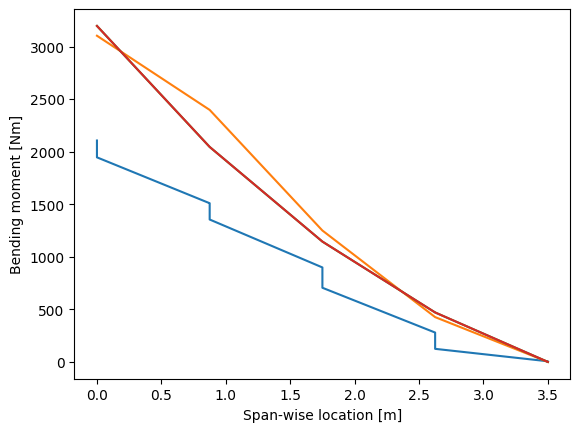

In [365]:
def buckling_constr(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    Buckling constraint for combined loading

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    buck = buckling(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)
    tarr = t_arr(b, L,t)
    vector = np.zeros(len(tarr))
    for i in range(len(tarr)):
        vector[i] = -1 * (buck[i] - 1)
    return vector[0]

#print(buckling_constr(7, 1.5, 0.003, 0.003, 0.12, 0.07, 0.003,0.003,0.004,[0.0022]))


def global_local(b, c_r, L, b_st, h_st,t_st,t):
    r"""

    Local Skin Buckling<Global Skin buckling constraint

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness


    t: np.array
    skin thikness

    """
    tarr = t_arr(b, L,t)
    diff = np.zeros(len(tarr))
    for i in range(len(tarr)):
        glob = global_buckling(c_r, b_st, h_st,t_st,tarr[i])
        loc = local_buckling(c_r, b_st,tarr[i])
        diff[i] = glob - loc
    return diff[0]


def local_column(b, c_r, L, b_st, h_st,t_st,w_st,t):
    r"""

    Local Skin Buckling<Column Stringer Buckling constraint

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    tarr = t_arr(b, L,t)
    diff = np.zeros(len(tarr))
    sta=rib_coordinates(b,L)
    for i in range(len(tarr)):
        col = column_st(b, L, h_st,t_st,w_st, tarr[i]) #(sta[i])
        loc = local_buckling(c_r, b_st, tarr[i])*tarr[i]
        diff[i] = col - loc
    return diff[0]


def flange_loc_loc(b, c_r, L, b_st, t_st,w_st,t):
    r"""

    Local Skin Buckling< Stringer Flange Buckling constraint

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord


    L: float
    rib pitch

    b_st: float
    stringer pitch

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    tarr = t_arr(b, L,t)
    diff = np.zeros(len(tarr))
    flange = flange_buckling(t_st, w_st)
    for i in range(len(tarr)):
        loc = local_buckling(c_r, b_st, tarr[i])
        diff[i] = flange - loc
    return diff[0]


def web_flange(b,c_r, L,b_st, h_st,t_st,t):
    r"""

    Local Skin< Stringer Web buckling constraint

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord


    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness


    t: np.array
    skin thikness

    """
    tarr = t_arr(b, L,t)
    diff = np.zeros(len(tarr))
    web = web_buckling(t_st, h_st)
    for i in range(len(tarr)):
        loc = local_buckling(c_r, b_st, tarr[i])
        diff[i] =web-loc
    return diff[0]


def von_Mises(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t):
    r"""

    von Mises yield criterion

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    tarr = t_arr(b, L,t)
    vm = np.zeros(len(tarr))
    Nxy=N_xy(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)
    bend_stress=N_x(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)[1]
    for i in range(len(tarr)):
        tau_shear= Nxy[i] / tarr[i]
        vm[i]=sigma_yield-sqrt(0.5 * (3 * tau_shear ** 2+bend_stress[i]**2))
    return vm[0]


def crippling(b,c_r,L,b_st, h_st,t_st,w_st,t):
    r"""

    Crippling constraint

    Parameters
    ----------

    b: float
    span

    L: float
    rib pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    tarr = t_arr(b, L,t)
    crip= np.zeros(len(tarr))
    A = area_st(h_st, t_st, w_st)
    for i in range(len(tarr)):
        col = column_st(b, L,h_st,t_st,w_st,tarr[i])
        crip[i] = t_st* beta *sigma_yield* ((g * t_st ** 2 / A) * sqrt(E / sigma_yield)) ** m_crip-col
    return crip[0]


def post_buckling(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st, t):
    r"""

    Post buckling constraint

    Parameters
    ----------

    b: float
    span

    c_r: float
    root chord

    t_sp: float
    spar thickness

    t_rib: float
    rib thickness

    L: float
    rib pitch

    b_st: float
    stringer pitch

    h_st: float
    stringer web height

    t_st: float
    stringer thickness

    w_st: float
    stringer flange width

    t: np.array
    skin thikness

    """
    f=f_ult(b,c_r,t_sp,L,b_st,h_st,t_st,w_st,t)
    ratio=2/(2+1.3*(1-1/pb))
    px= n_max*shear_force(b, c_r, t_sp, t_rib, L, b_st, h_st,t_st,w_st,t)
    diff=np.subtract(ratio*f,px)
    return diff[0]



#print(f"global_local = {global_local(b,c_r, L,b_st, h_st,t_st,[t])}")
#print(f"post_buckling = {post_buckling(b, c_r, t_spar, t_rib, L, b_st, h_st,t_st,w_st, [t])}")
#print(f"von_Mises = {von_Mises(b, c_r, t_spar, t_rib, L, b_st, h_st,t_st,w_st,[t])}")
#print(f"bucklin_constr = {buckling_constr(b, c_r, t_spar, t_rib, L, b_st, h_st,t_st,w_st,[t])}")
#print(f"web flange = {web_flange(b,c_r, L, b_st, h_st, t_st, [t])}")
#print(f"crippling = {crippling(b,c_r, L, b_st, h_st, t_st, w_st,  [t])}")
print(f"local - column= {local_column(b ,c_r, L,  b_st, h_st, t_st, w_st,  [t])}")
print(f"flange loc loc= {flange_loc_loc(b,c_r, L, b_st, t_st, w_st,  [t])}")
